In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import statsmodels.api as sm

In [2]:
# Cargar datos

df = pd.read_parquet('../data/df_2.parquet')

In [3]:
df.head()

,fecha,precio,demanda,log_precio,log_demanda,mes,dia_semana
0,2022-01-01,1024.835708,495.403900,6.932288,6.205373,1,5
1,2022-01-02,993.086785,483.797246,6.900818,6.181666,1,6
2,2022-01-03,1032.384427,498.991268,6.939626,6.212589,1,0
3,2022-01-04,1076.151493,443.690034,6.981147,6.095126,1,1
4,2022-01-05,988.292331,528.443462,6.895979,6.269936,1,2


In [4]:
# Estimación del modelo

modelo = ols('log_demanda ~ log_precio + C(mes) + C(dia_semana)', data=df).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            log_demanda   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     88.24
Date:                Fri, 13 Sep 2024   Prob (F-statistic):          2.28e-167
Time:                        16:17:14   Log-Likelihood:                 1230.5
No. Observations:                 730   AIC:                            -2423.
Df Residuals:                     711   BIC:                            -2336.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.7788      0

se recomienda eliminar algunas variables del modelo. Específicamente:

1. Todas las variables de día de la semana (C(dia_semana)[T.1] a C(dia_semana)[T.6]).
2. Posiblemente la variable para diciembre (C(mes)[T.12]).

La razón principal es que estas variables no son estadísticamente significativas en el modelo actual. Eliminarlas podría mejorar la parsimonia del modelo sin sacrificar mucho poder explicativo.

In [5]:
df = df.drop('dia_semana', axis=1)

df['mes'] = df['mes'].replace({12:1}) # Redefinimos la variable mes para cambiar deciembre con enero

In [6]:
modelo_2 = ols('log_demanda ~ log_precio + C(mes)', data=df).fit()
print(modelo_2.summary())

                            OLS Regression Results                            
Dep. Variable:            log_demanda   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 13 Sep 2024   Prob (F-statistic):          6.40e-173
Time:                        16:24:30   Log-Likelihood:                 1226.5
No. Observations:                 730   AIC:                            -2429.
Df Residuals:                     718   BIC:                            -2374.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.7804      0.237     45.560   

**Interpretación del Modelo de Elasticidad Precio de la Demanda - Modelo Refinado**

Comparación de Estadísticas Generales

1. R-cuadrado y R-cuadrado ajustado:

* Modelo original: R-cuadrado = 0.691, R-cuadrado ajustado = 0.683
* Modelo refinado: R-cuadrado = 0.687, R-cuadrado ajustado = 0.683

El R-cuadrado ajustado se mantiene igual, lo que indica que no hemos perdido poder explicativo al eliminar las variables.

2. F-statistic y Prob (F-statistic):

* Modelo original: F-statistic = 88.24, Prob (F-statistic) = 2.28e-167
* Modelo refinado: F-statistic = 143.5, Prob (F-statistic) = 6.40e-173

El F-statistic ha aumentado y el p-valor ha disminuido, lo que sugiere que el modelo refinado es aún más significativo en general.

3. AIC y BIC:

* Modelo original: AIC = -2423, BIC = -2336
* Modelo refinado: AIC = -2429, BIC = -2374

Tanto AIC como BIC han mejorado (valores más bajos), lo que indica que el modelo refinado es preferible en términos de equilibrio entre ajuste y complejidad.

4. Coeficientes

* log_precio:

Modelo original: -0.6535 (p-valor = 0.000)
Modelo refinado: -0.6532 (p-valor = 0.000)

La elasticidad precio de la demanda estimada prácticamente no ha cambiado y sigue siendo altamente significativa.

* Meses (C(mes)[T.X]):

Todos los coeficientes de los meses siguen siendo estadísticamente significativos (p < 0.05).
Los coeficientes son muy similares a los del modelo original.


* Variables eliminadas:

Se eliminaron todas las variables de día de la semana y el mes de diciembre (que se combinó con enero).



* Diagnósticos

    * Durbin-Watson:

Modelo original: 1.404
Modelo refinado: 1.415

Ha habido una ligera mejora, pero aún podría haber cierta autocorrelación positiva en los residuos.

    * Omnibus y Jarque-Bera:

Modelo original: Prob(Omnibus) = 0.595, Prob(JB) = 0.573
Modelo refinado: Prob(Omnibus) = 0.615, Prob(JB) = 0.589

Ambos tests siguen sin rechazar la hipótesis nula de normalidad de los residuos.

    * Condición Número:

Modelo original: 997
Modelo refinado: 992

Ha habido una ligera mejora, pero el valor sigue siendo alto, lo que podría indicar cierta multicolinealidad.

Conclusiones

* El modelo refinado mantiene el mismo poder explicativo (R-cuadrado ajustado) que el modelo original, pero con menos variables.
* La elasticidad precio de la demanda estimada es prácticamente idéntica (-0.6532), lo que refuerza la robustez de esta estimación.
* La eliminación de las variables de día de la semana y la combinación de diciembre con enero han simplificado el modelo sin pérdida de ajuste.
* Los criterios de información (AIC y BIC) han mejorado, lo que sugiere que el modelo refinado es preferible al original.
* Los diagnósticos de los supuestos del modelo (normalidad, autocorrelación) se mantienen similares o han mejorado ligeramente.

## Implementación de errores estandar robustos

1. ¿Qué son los errores estándar robustos?
Los errores estándar robustos son una técnica para calcular errores estándar que son consistentes incluso cuando se violan ciertos supuestos del modelo, como la homocedasticidad (varianza constante de los errores) o la ausencia de autocorrelación.
2. ¿Por qué usarlos?
En este caso, el estadístico de Durbin-Watson (1.415) sugería una posible autocorrelación en los residuos. Los errores estándar robustos pueden ayudar a obtener inferencias más confiables en presencia de autocorrelación y heterocedasticidad.

In [22]:
# Preprocesamiento de datos
def preprocess_data(df):
    # Asegurarse de que 'log_precio' y 'log_demanda' sean numéricas
    df['log_precio'] = pd.to_numeric(df['log_precio'], errors='coerce')
    df['log_demanda'] = pd.to_numeric(df['log_demanda'], errors='coerce')
    
    # Convertir 'mes' a categórica si no lo es ya
    df['mes'] = pd.Categorical(df['mes'])
    
    # Eliminar filas con valores nulos
    df = df.dropna(subset=['log_precio', 'log_demanda', 'mes'])
    
    return df

In [23]:
# Aplicar preprocesamiento
df_clean = preprocess_data(df)

# Preparar los datos
y = df_clean['log_demanda']
X = pd.get_dummies(df_clean[['log_precio', 'mes']], columns=['mes'], drop_first=True)
X = sm.add_constant(X)

# Convertir X a numpy array
X = X.astype(float).to_numpy()



In [24]:
# Modelo OLS con errores estándar robustos
try:
    modelo_robusto = sm.OLS(y, X).fit(cov_type='HC3')
    print(modelo_robusto.summary())
    
    # Comparar coeficientes y errores estándar
    print("\nComparación de coeficientes y errores estándar:")
    print("Variable    | Coef (Robusto) | Std Err (Robusto)")
    print("------------------------------------------------")
    for i, var in enumerate(["const", "log_precio"] + [f"mes_{j}" for j in range(2, 12)]):
        coef_rob = modelo_robusto.params[i]
        se_rob = modelo_robusto.bse[i]
        print(f"{var:11} | {coef_rob:14.4f} | {se_rob:17.4f}")

    # Calcular intervalos de confianza robustos
    ci_robusto = modelo_robusto.conf_int()
    print("\nIntervalos de confianza robustos:")
    print(ci_robusto)

    # Enfocarse en la elasticidad precio de la demanda
    elasticidad = modelo_robusto.params[1]  # Índice 1 corresponde a log_precio
    ci_elasticidad = ci_robusto[1]
    print(f"\nElasticidad precio de la demanda (robusta): {elasticidad:.4f}")
    print(f"Intervalo de confianza al 95% (robusto): ({ci_elasticidad[0]:.4f}, {ci_elasticidad[1]:.4f})")
    
except Exception as e:
    print("Se produjo un error al ajustar el modelo:")
    print(str(e))
    print("\nVerifica los primeros registros de X:")
    print(X[:5])
    print("\nVerifica los primeros registros de y:")
    print(y.head())

                            OLS Regression Results                            
Dep. Variable:            log_demanda   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 13 Sep 2024   Prob (F-statistic):          6.64e-173
Time:                        16:49:22   Log-Likelihood:                 1226.5
No. Observations:                 730   AIC:                            -2429.
Df Residuals:                     718   BIC:                            -2374.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7804      0.243     44.412      0.0

C:\Users\User\AppData\Local\Temp\ipykernel_5812\3786025060.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_rob = modelo_robusto.params[i]
C:\Users\User\AppData\Local\Temp\ipykernel_5812\3786025060.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_rob = modelo_robusto.bse[i]
C:\Users\User\AppData\Local\Temp\ipykernel_5812\3786025060.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elasticidad = modelo_robusto.para

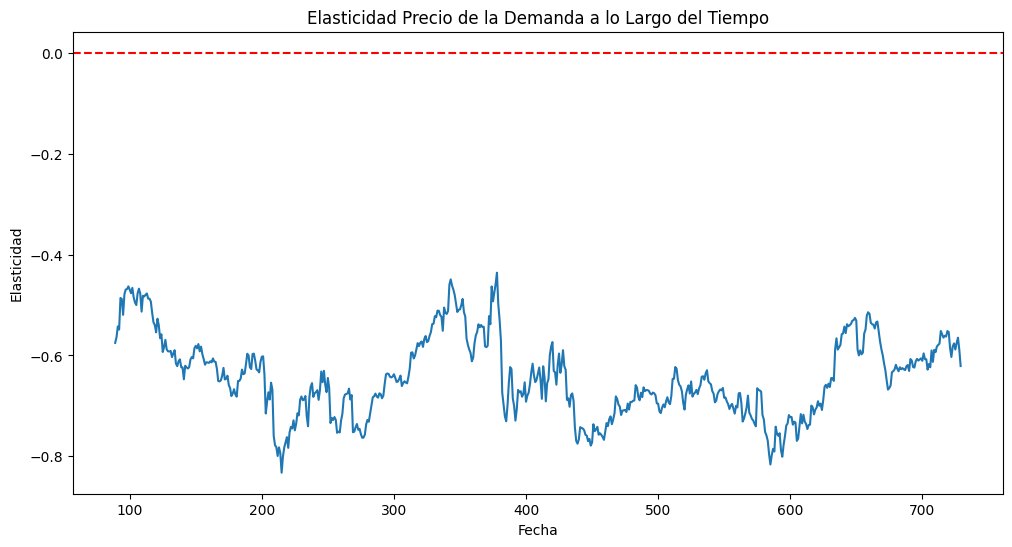

In [25]:
def calculate_elasticity(df, window_size):
    elasticities = []
    dates = []
    
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size]
        y = window['log_demanda']
        X = sm.add_constant(window[['log_precio']])
        model = sm.OLS(y, X).fit()
        elasticities.append(model.params['log_precio'])
        dates.append(window.index[-1])
    
    return pd.Series(elasticities, index=dates)

# Asumiendo que df es tu DataFrame con las columnas necesarias
window_size = 90  # Por ejemplo, una ventana de 90 días
elasticities = calculate_elasticity(df, window_size)

plt.figure(figsize=(12, 6))
plt.plot(elasticities.index, elasticities.values)
plt.title('Elasticidad Precio de la Demanda a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Elasticidad')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [29]:
elasticities.describe()

count    641.000000
mean      -0.643151
std        0.078691
min       -0.832420
25%       -0.697106
50%       -0.651145
75%       -0.589826
max       -0.436002
dtype: float64